DONE:
- ignorer les valeurs nan dans le churn, car c'est le cas "l'incertitude totale"
- filtrer l'age entre 20 et 59 ans
- matrice de correlation sur les donnees numeriques
- utiliser toutes les donnees chaudes (avec nan)
- utiliser tous les champs comme les features
- resoudre le probleme de desequilibre (SMOTEENN)

# Envouthe Churn Prediction

Envouthé souhaite réduire le % de churn et investir les efforts marketing sur les clients à risques (70% de risque de non renouvellement de l’abonnement) afin qu’ils renouvellent leur abonnement.

**Context**
- Les clients Envouthé peuvent souscrire à des abonnements mensuels, trimestriels, semestriels et annuels.
- A l’issue de la date de fin d’abonnement, le client doivent renouveler son abonnement.
- Dans le même lapse de temps, l'équipe marketing Envouthé envoie régulièrement un certain nombre d'emails promotionnels et d’emails d’informations.

**Objectif**
- Prédire le risque de churn pour les clients en fin d’abonnement

**Description du use case retenu:**
- En fonction du comportement des clients, l’algorithme va déduire un score de 0 à 1 (0 pas d'appétence au renouvellement ; 1 appétence au renouvellement forte)  
- si appétence > 0,7; pas d’action particulière
- si appétence entre 0,3 et 0,7 , c'est une visiteur tiède, le marketing pourra envoyer des offres marketing afin d’augmenter le % de renouvellement
- sinon: envoi d’une enquête satisfaction client

**Columns**
- id_subscriptionMain: id d'abonnement
- id_order: id de commande
- client_name: nom de client
- email: email de client
- box_name: nom de box
- subscriptions_type: type d'abonnement. Le numéro signifie que la durée de l’abonnement/la durée des échéances d’abonnement prévues dans le système. 
- month: la date du mois qui s'est écoulé depuis la date de début
- submain_state: le statut d'abonnement.
- product_attribute: l'attribut de produit	
- id: id de client
- last_name: nom de famille de client
- newsletter: si l'utilisateur inscrit le newsletter ou pas
- age: age de client
- beginning_date: date de debut d'abonnement
- ending_date: date de fin d'abonnement
- first_name: prenom de client
- abonnement_succ: si l'abonnement est active le mois suivant ou pas
- total_sub: nombre total d'abonnements
- abonnement_consec: la durée de l'abonnement effectif par rapport a la date de début
- churn: si l'abonnement va renouveller ou pas
- campaign_id: id de campagne.
- email_id: id d'email reçu
- Timestamp: la date de l'action.
- action_open: nbr d'ouverture.
- action_click: nbr de click.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import copy
import seaborn as sns
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


print(tf.__version__)

1.12.0


In [2]:
dataset = pd.read_csv('../../donnees/final_v1.csv')
dataset.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,month,submain_state,product_attribute,id,...,total_sub,abonnement_consec,churn,campaign_id,list_id,list_is_active,email_id,Timestamp,action_open,action_click
0,3161,25661,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/04/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'...",19717,...,1,1,Yes,001fda10d5,e6c6373c83,True,a99f89fb19a6b963e10bc733226ed55b,NaN,NaN,NaN
1,1621,27750,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/10/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'...",19717,...,2,1,No,001fda10d5,e6c6373c83,True,a99f89fb19a6b963e10bc733226ed55b,NaN,NaN,NaN
2,1621,27750,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/11/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'...",19717,...,3,2,No,001fda10d5,e6c6373c83,True,a99f89fb19a6b963e10bc733226ed55b,NaN,NaN,NaN
3,1621,27750,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/12/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'...",19717,...,4,3,Yes,001fda10d5,e6c6373c83,True,a99f89fb19a6b963e10bc733226ed55b,NaN,NaN,NaN
4,18129,2319,Cheyrou Sandrine,100driiine@reverdailleurs.com,Abonnement mensuel,64,01/12/2012,SUSPENDED,"Durée de l'abonnement :illimité, Fréquence d'...",2567,...,1,1,No,001fda10d5,e6c6373c83,True,a5a4e382d254c5dca807536aa5a507cf,NaN,NaN,NaN


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30505 entries, 0 to 30504
Data columns (total 27 columns):
id_subscriptionMain    30505 non-null int64
id_order               30505 non-null int64
client_name            30505 non-null object
email                  30505 non-null object
box_name               30505 non-null object
subscriptions_type     30505 non-null int64
month                  30505 non-null object
submain_state          30505 non-null object
product_attribute      30505 non-null object
id                     30505 non-null int64
last_name              30505 non-null object
newsletter             30505 non-null bool
age                    9228 non-null float64
beginning_date         30505 non-null object
ending_date            30505 non-null object
first_name             30505 non-null object
abonnement_succ        29858 non-null object
total_sub              30505 non-null int64
abonnement_consec      30505 non-null int64
churn                  29858 non-null object

In [4]:
# vérifier le nombre de valeurs nulles
dataset.isnull().sum()

id_subscriptionMain        0
id_order                   0
client_name                0
email                      0
box_name                   0
subscriptions_type         0
month                      0
submain_state              0
product_attribute          0
id                         0
last_name                  0
newsletter                 0
age                    21277
beginning_date             0
ending_date                0
first_name                 0
abonnement_succ          647
total_sub                  0
abonnement_consec          0
churn                    647
campaign_id                0
list_id                    0
list_is_active             0
email_id                   0
Timestamp              27841
action_open            27841
action_click           27841
dtype: int64

In [5]:
# vérifier le nombre de classifications sur chaque champ
dataset.nunique()

id_subscriptionMain    3747
id_order               3747
client_name            2414
email                  2418
box_name                  2
subscriptions_type       40
month                    92
submain_state             4
product_attribute         2
id                     2418
last_name              1606
newsletter                2
age                      56
beginning_date         1215
ending_date              80
first_name             2027
abonnement_succ           2
total_sub                75
abonnement_consec        75
churn                     2
campaign_id               4
list_id                   4
list_is_active            1
email_id               2418
Timestamp               179
action_open              10
action_click              4
dtype: int64

In [6]:
dataset.describe()

,id_subscriptionMain,id_order,subscriptions_type,id,age,total_sub,abonnement_consec,action_open,action_click
count,30505.000000,30505.000000,30505.000000,30505.000000,9228.000000,30505.000000,30505.000000,2664.000000,2664.000000
mean,14040.412129,22524.638977,14.504770,14754.023832,35.354031,11.987707,10.448713,1.356607,0.608483
std,7049.389104,15666.789282,8.655119,11896.452733,11.370212,11.272552,10.384226,1.328678,0.659615
min,7.000000,2.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,8566.000000,10119.000000,12.000000,5177.000000,28.000000,4.000000,3.000000,1.000000,0.000000
50%,14541.000000,19344.000000,12.000000,11568.000000,33.000000,9.000000,7.000000,1.000000,1.000000
75%,19376.000000,38184.000000,12.000000,22862.000000,41.000000,16.000000,13.000000,1.000000,1.000000
max,29579.000000,59951.000000,64.000000,46817.000000,76.000000,75.000000,75.000000,15.000000,3.000000


## data preprocessing

In [7]:
df = copy.deepcopy(dataset)

# supprimer les champs
df = df.drop(columns=['product_attribute', 'id', 'id_order', 'campaign_id', 'email_id', 'list_id', 'list_is_active']) # champ inutile
df = df.drop('first_name', axis = 1) # c'est le meme que le champ client_name
df = df.drop('last_name', axis = 1) # c'est le meme que le champ client_name

# supprimer les duplicates
df = df.drop_duplicates(df.columns, keep='last') 

df.head()

,id_subscriptionMain,client_name,email,box_name,subscriptions_type,month,submain_state,newsletter,age,beginning_date,ending_date,abonnement_succ,total_sub,abonnement_consec,churn,Timestamp,action_open,action_click
0,3161,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/04/2016,CANCELED,False,NaN,16/10/2016,31/12/2016,False,1,1,Yes,NaN,NaN,NaN
1,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/10/2016,CANCELED,False,NaN,16/10/2016,31/12/2016,True,2,1,No,NaN,NaN,NaN
2,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/11/2016,CANCELED,False,NaN,16/10/2016,31/12/2016,True,3,2,No,NaN,NaN,NaN
3,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,01/12/2016,CANCELED,False,NaN,16/10/2016,31/12/2016,False,4,3,Yes,NaN,NaN,NaN
4,18129,Cheyrou Sandrine,100driiine@reverdailleurs.com,Abonnement mensuel,64,01/12/2012,SUSPENDED,False,NaN,18/12/2012,30/04/2018,True,1,1,No,NaN,NaN,NaN


In [8]:
# definir les donnees numeriques et les donnees categoriques
date_col = ['month', 'beginning_date', 'ending_date']
bool_col = ['newsletter', 'abonnement_succ']
numerique = ['subscriptions_type', 'age', 'abonnement_consec', 'total_sub', 'action_open', 'action_click']
categorique = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'month', 'beginning_date', 'ending_date', \
                                                                  'newsletter', 'abonnement_succ', 'subscriptions_type', 'age', 'abonnement_consec',\
                                                                  'total_sub', 'action_open', 'action_click']]

x_date = df[date_col]
x_bool = df[bool_col]
x_numerique = df[numerique]
x_categorique = df[categorique]

print(x_date.shape, x_bool.shape, x_numerique.shape, x_categorique.shape)

(30335, 3) (30335, 2) (30335, 6) (30335, 6)


**preprocessing sur les dates**

In [9]:
# verifier les valeurs nulles
print(x_date.isnull().sum())

month             0
beginning_date    0
ending_date       0
dtype: int64


In [10]:
# extraire le jours et le mois
df['month'] = pd.to_datetime(df['month'])
df['beginning_date'] = pd.to_datetime(df['beginning_date'])
df['ending_date'] = pd.to_datetime(df['ending_date'])

# on ignore le jour, car c'est toujours le 1 du mois
df['year_pass'] = df['month'].dt.year
df['month_pass'] = df['month'].dt.day # extraire le jours ici, car le format du champ month inverse le mois et le jours

df['begin_year'] = df['beginning_date'].dt.year
df['begin_month'] = df['beginning_date'].dt.month
df['begin_day'] = df['beginning_date'].dt.day

df['end_year'] = df['ending_date'].dt.year
df['end_month'] = df['ending_date'].dt.month
df['end_day'] = df['ending_date'].dt.day

In [11]:
#supprimer les champs month et ending_month
df = df.drop(columns=['month','beginning_date', 'ending_date'])

df.head()

,id_subscriptionMain,client_name,email,box_name,subscriptions_type,submain_state,newsletter,age,abonnement_succ,total_sub,...,action_open,action_click,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3161,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,CANCELED,False,NaN,False,1,...,NaN,NaN,2016,4,2016,10,16,2016,12,31
1,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,CANCELED,False,NaN,True,2,...,NaN,NaN,2016,10,2016,10,16,2016,12,31
2,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,CANCELED,False,NaN,True,3,...,NaN,NaN,2016,11,2016,10,16,2016,12,31
3,1621,Mélanie Corsin,09claire.ny@gmail.com,Abonnement mensuel,12,CANCELED,False,NaN,False,4,...,NaN,NaN,2016,12,2016,10,16,2016,12,31
4,18129,Cheyrou Sandrine,100driiine@reverdailleurs.com,Abonnement mensuel,64,SUSPENDED,False,NaN,True,1,...,NaN,NaN,2012,12,2012,12,18,2018,4,30


**preprocessing sur les champs categoriques**

In [12]:
df3 = copy.deepcopy(df)
# df = copy.deepcopy(df3)

In [13]:
# verifier les valeurs nulles
x_categorique = df[categorique]
print(x_categorique.isnull().sum())

client_name          0
email                0
box_name             0
submain_state        0
churn              646
Timestamp        27671
dtype: int64


In [14]:
# supprimer les champs qui ont trop de categoriques
# le champ Timestamp contient les actions de l'ouverture et de click, mais on a deja le champ action_open et action_click, donc, on supprime ce champ
df = df.drop(columns=['client_name','email','Timestamp'])

In [15]:
print(df['box_name'].unique())
print(df['submain_state'].unique())
print(df['churn'].unique())

['Abonnement mensuel' 'Abonnement trimestriel']
['CANCELED' 'SUSPENDED' 'ACTIVE' 'WARNING']
['Yes' 'No' nan]


In [16]:
# convertir les valeurs categorique en valeurs numeriques

# box_name
df['box_name'] = df['box_name'].replace(['Abonnement mensuel', 'Abonnement trimestriel'],[0,1])

# submain_state
df['submain_state'] = df['submain_state'].replace(['CANCELED','SUSPENDED','ACTIVE','WARNING'],[0,1,2,3])

# churn
df = df.dropna(subset=["churn"]) # l'incertitude totale
df['churn'] = df['churn'].replace(['No','Yes'],[0,1]) # cas churn et cas non churn

df.head()

,id_subscriptionMain,box_name,subscriptions_type,submain_state,newsletter,age,abonnement_succ,total_sub,abonnement_consec,churn,action_open,action_click,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3161,0,12,0,False,NaN,False,1,1,1,NaN,NaN,2016,4,2016,10,16,2016,12,31
1,1621,0,12,0,False,NaN,True,2,1,0,NaN,NaN,2016,10,2016,10,16,2016,12,31
2,1621,0,12,0,False,NaN,True,3,2,0,NaN,NaN,2016,11,2016,10,16,2016,12,31
3,1621,0,12,0,False,NaN,False,4,3,1,NaN,NaN,2016,12,2016,10,16,2016,12,31
4,18129,0,64,1,False,NaN,True,1,1,0,NaN,NaN,2012,12,2012,12,18,2018,4,30


**preprocessing sur les donnees numeriques**

In [17]:
df2 = copy.deepcopy(df)
# df = copy.deepcopy(df2)

In [18]:
# verifier les valeurs nulles
x_numerique = df[numerique]
print(x_numerique.isnull().sum())

subscriptions_type        0
age                   20789
abonnement_consec         0
total_sub                 0
action_open           27109
action_click          27109
dtype: int64


In [19]:
df.age.min(), df.age.max()

(1.0, 76.0)

In [20]:
# transformer l'age en tranche d'age
df.loc[(df.age<10), 'age'] = 0 # age < 10 ans
df.loc[(df.age>=10) & (df.age<20), 'age'] = 1 # age entre 10 et 19 ans
df.loc[(df.age>=20) & (df.age<30), 'age'] = 2 # age entre 20 et 29 ans
df.loc[(df.age>=30) & (df.age<40), 'age'] = 3 # age entre 30 et 39 ans
df.loc[(df.age>=40) & (df.age<50), 'age'] = 4 # age entre 40 et 49 ans
df.loc[(df.age>=50) & (df.age<60), 'age'] = 5 # age entre 50 et 59 ans
df.loc[(df.age>=60) & (df.age<70), 'age'] = 6 # age entre 60 et 69 ans
df.loc[(df.age>=70), 'age'] = 7 # age entre 70 et 79 ans
df.loc[(df.age.isnull()), 'age'] = 8 # not have age

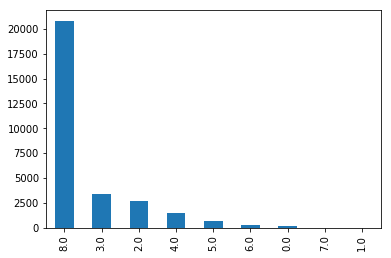

In [21]:
fig = plt.figure()

df.age.value_counts().plot(kind='bar')
plt.show()

In [22]:
print(df.shape)
# filtrer les clients qui ont l'age entre 20 et 59, et les valuers nulles
df = df[((df.age >= 2) & (df.age <= 5)) | (df.age == 8)]
print(df.shape)

(29689, 20)
(29180, 20)


In [23]:
# on peut completer les valeurs nulles par median, mais il y a nombreux valeurs nulles sur le champ age, cela va prendre beaucoup de bruit
# sinon on prend en compte les valeurs nulles comme une type
# alors, on va transformer le champ age par deux valeurs: have age et not have age

df.loc[df.age != 8, 'age'] = 1
df.loc[df.age == 8, 'age'] = 0
df.age = df.age.astype(int)

In [24]:
df.age.value_counts()

0    20789
1     8391
Name: age, dtype: int64

In [25]:
# garder les valeurs nulles des champs 'action_open' et 'action_click'
# convertir les valeurs nulles comme une valeur specifique
df.loc[df.action_open.isnull(), 'action_open'] = -1

In [26]:
df.action_open.value_counts()

-1.0     26648
 1.0      1615
 0.0       334
 2.0       295
 3.0       191
 7.0        45
 8.0        14
 4.0        14
 6.0        13
 5.0         8
 15.0        3
Name: action_open, dtype: int64

In [27]:
df.loc[df.action_click.isnull(), 'action_click'] = -1

In [28]:
df.action_click.value_counts()

-1.0    26648
 1.0     1240
 0.0     1192
 3.0       69
 2.0       31
Name: action_click, dtype: int64

**preprocessing sur les donnees boolean**

In [29]:
df1 = copy.deepcopy(df)
# df = copy.deepcopy(df1)

In [30]:
# verifier les valeurs nulles
x_bool = df[bool_col]
print(x_bool.isnull().sum())

newsletter         0
abonnement_succ    0
dtype: int64


In [31]:
df['newsletter'] = df['newsletter'].replace([False,True],[0,1])
df['abonnement_succ'] = df['abonnement_succ'].replace([False, True], [0,1])

df.head()

,id_subscriptionMain,box_name,subscriptions_type,submain_state,newsletter,age,abonnement_succ,total_sub,abonnement_consec,churn,action_open,action_click,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3161,0,12,0,0,0,0,1,1,1,-1.0,-1.0,2016,4,2016,10,16,2016,12,31
1,1621,0,12,0,0,0,1,2,1,0,-1.0,-1.0,2016,10,2016,10,16,2016,12,31
2,1621,0,12,0,0,0,1,3,2,0,-1.0,-1.0,2016,11,2016,10,16,2016,12,31
3,1621,0,12,0,0,0,0,4,3,1,-1.0,-1.0,2016,12,2016,10,16,2016,12,31
4,18129,0,64,1,0,0,1,1,1,0,-1.0,-1.0,2012,12,2012,12,18,2018,4,30


**heat map pour la correlation**

In [32]:
# definir les features et le label
ids = ['id_subscriptionMain']
label = ['churn']

features = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'churn']]
data = [j for j in df.columns.values.tolist() if j not in ['id_subscriptionMain']]

df_id = df[ids] # id_subscriptionMain, id_order et id
df_data = df[data] # features + label
df_features = df[features] # tous les champs sauf ids et churn
df_label = df[label] # churn

In [33]:
df_id.shape, df_data.shape, df_features.shape, df_label.shape

((29180, 1), (29180, 19), (29180, 18), (29180, 1))

In [34]:
df = pd.concat((df_id, df_features, df_label),axis=1)
df.head()

,id_subscriptionMain,box_name,subscriptions_type,submain_state,newsletter,age,abonnement_succ,total_sub,abonnement_consec,action_open,action_click,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day,churn
0,3161,0,12,0,0,0,0,1,1,-1.0,-1.0,2016,4,2016,10,16,2016,12,31,1
1,1621,0,12,0,0,0,1,2,1,-1.0,-1.0,2016,10,2016,10,16,2016,12,31,0
2,1621,0,12,0,0,0,1,3,2,-1.0,-1.0,2016,11,2016,10,16,2016,12,31,0
3,1621,0,12,0,0,0,0,4,3,-1.0,-1.0,2016,12,2016,10,16,2016,12,31,1
4,18129,0,64,1,0,0,1,1,1,-1.0,-1.0,2012,12,2012,12,18,2018,4,30,0


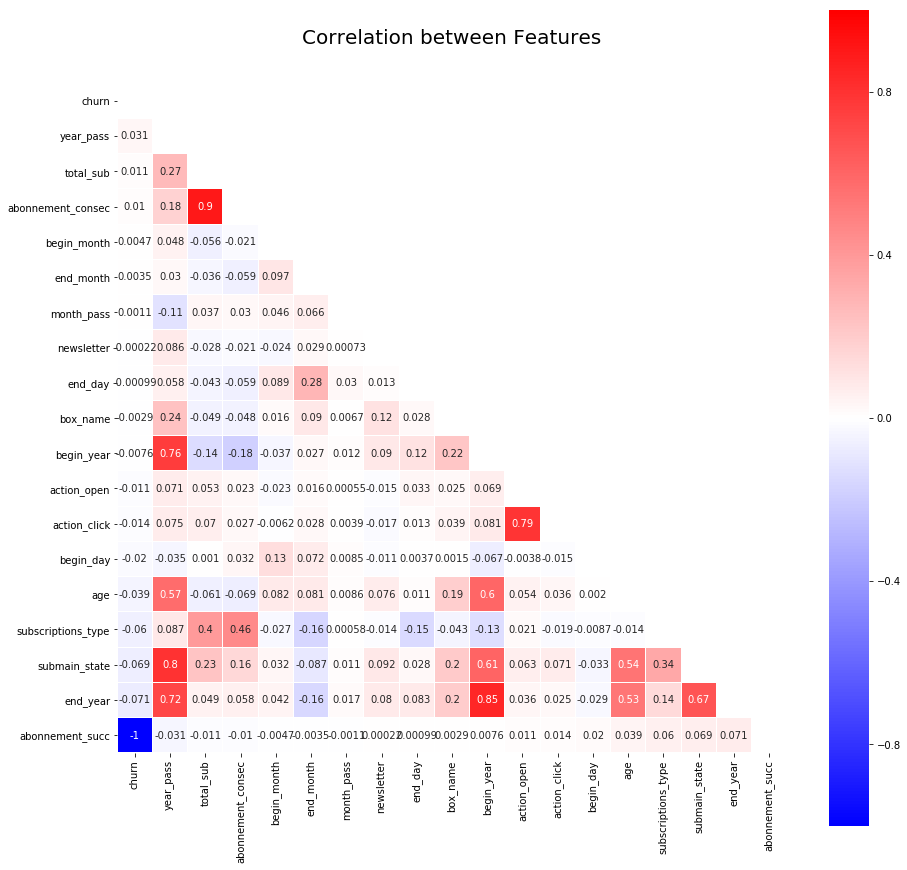

In [35]:
# Heat map pour la correlation entre les features
colormap = plt.cm.bwr
# colormap.set_size
plt.figure(figsize=(15,15))
plt.title('Correlation between Features', y=1.05, size = 20)

k = len(df_data)

# Generate a mask for the upper triangle
corr = df_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cols = corr.nlargest(k, 'churn')['churn'].index
cm = np.corrcoef(df[cols].values.T)

# heatmap
sns.heatmap(cm,
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True,
           mask = mask,
           yticklabels=cols.values, 
            xticklabels=cols.values)

plt.show()

In [36]:
# regarder la correlation avec le champ churn
df_data.corr()["churn"].sort_values(ascending=False)

churn                 1.000000
year_pass             0.031250
total_sub             0.010511
abonnement_consec     0.010153
begin_month           0.004707
end_month             0.003510
month_pass            0.001104
newsletter           -0.000219
end_day              -0.000995
box_name             -0.002884
begin_year           -0.007642
action_open          -0.011094
action_click         -0.014499
begin_day            -0.019924
age                  -0.039414
subscriptions_type   -0.059626
submain_state        -0.068514
end_year             -0.071424
abonnement_succ      -1.000000
Name: churn, dtype: float64

In [37]:
# le champ abonnement_succ est totalement negativement correle, on ne le considere pas comme le feature
df = df.drop(columns='abonnement_succ')

**normalisation**

In [38]:
df.iloc[:,1:-1] = normalize(df.iloc[:,1:-1])

df.head()

,id_subscriptionMain,box_name,subscriptions_type,submain_state,newsletter,age,total_sub,abonnement_consec,action_open,action_click,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day,churn
0,3161,0.0,0.003436,0.000000,0.0,0.0,0.000286,0.000286,-0.000286,-0.000286,0.577312,0.001145,0.577312,0.002864,0.004582,0.577312,0.003436,0.008877,1
1,1621,0.0,0.003436,0.000000,0.0,0.0,0.000573,0.000286,-0.000286,-0.000286,0.577310,0.002864,0.577310,0.002864,0.004582,0.577310,0.003436,0.008877,0
2,1621,0.0,0.003436,0.000000,0.0,0.0,0.000859,0.000573,-0.000286,-0.000286,0.577309,0.003150,0.577309,0.002864,0.004582,0.577309,0.003436,0.008877,0
3,1621,0.0,0.003436,0.000000,0.0,0.0,0.001145,0.000859,-0.000286,-0.000286,0.577308,0.003436,0.577308,0.002864,0.004582,0.577308,0.003436,0.008877,1
4,18129,0.0,0.018343,0.000287,0.0,0.0,0.000287,0.000287,-0.000287,-0.000287,0.576643,0.003439,0.576643,0.003439,0.005159,0.578363,0.001146,0.008598,0


## machine learning
**definir les features**

In [39]:
df5 = copy.deepcopy(df)
# df = copy.deepcopy(df5)

In [40]:
ids = ['id_subscriptionMain']
label = ['churn']

features = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'churn']]
data = [j for j in df.columns.values.tolist() if j not in ['id_subscriptionMain']]

df_id = df[ids] # id_subscriptionMain, id_order et id
df_data = df[data] # features + label
df_features = df[features] # tous les champs sauf ids et churn
df_label = df[label] # churn

In [41]:
# utiliser ExtraTreesClassifier pour calculer l'importance de features
from sklearn.ensemble import ExtraTreesClassifier

df_imp = df_features

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(df_imp, df['churn'])

In [42]:
feats = pd.DataFrame()
feats['feature'] = df_imp.columns
feats['importance'] = clf.feature_importances_

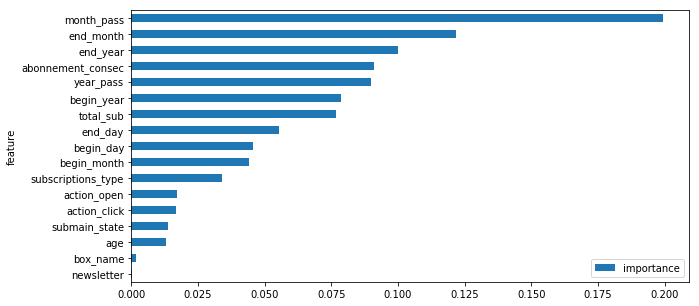

In [43]:
feats.sort_values(by=['importance'], ascending=True, inplace=True)
feats.set_index('feature', inplace=True)

feats.plot(kind='barh', figsize=(10, 5))
plt.legend(loc='lower right')

methode 1: choisir les features les plus importants

In [44]:
# # utiliser SelectFromModel a chosir les features les plus importants
# from sklearn.feature_selection import SelectFromModel

# mdl = SelectFromModel(clf, prefit=True)
# df_imp_new = mdl.transform(df_imp)

# print(df_imp_new.shape)

In [45]:
# indices = mdl.get_support(indices=False)
# df_new = df_imp.loc[:, indices]
# # df_new.head()
# df = pd.concat((df.iloc[:, :1], df_new, df['churn']), axis=1)
# df.head()

In [46]:
# train_data = df.columns.values.tolist()
# train_features = [i for i in train_data if i not in ['id_subscriptionMain', 'churn']]

# df = df[train_data]
# df_features = df[train_features]

methode 2: utiliser tous les champs comme features

In [47]:
train_data = df.columns.values.tolist()
train_features = [i for i in train_data if i not in ['id_subscriptionMain', 'churn']]

df = df[train_data]
df_features = df[train_features]

**splitting data**

In [48]:
df6 = copy.deepcopy(df)
# df = copy.deepcopy(df6)

In [49]:
# # # echantilloner au hasard une quantite des données, car svm coute trop de temps si la quantitie des donnees est trop grande.
print(df.shape)
df = df.sample(frac=0.2, random_state=70, axis=0)

print(df.shape)

(29180, 19)
(5836, 19)


In [50]:
# taille train : test = 8:2
train,test = train_test_split(df,test_size = .2 ,random_state = 40)

test_id_sub = test['id_subscriptionMain'].astype(int)

cols = [i for i in df_features.columns.values.tolist()]
chaudes = [i for i in ['action_open', 'action_click']]

train_X = train[cols]
train_Y = train['churn']

test_X  = test[cols]
test_Y  = test['churn']

print(train_Y.value_counts())

0    4289
1     379
Name: churn, dtype: int64


**equilibrer les donnees**

on trouve que le churn contient trop de valeur 0, on va donc equilibrer les donnees

In [51]:
df_train = copy.deepcopy(train)
# train = copy.deepcopy(df_train)

In [52]:
train_X = train[cols]
train_Y = train['churn']

data_cols = [i for i in train_X.columns.values.tolist()]

X_sampled = train_X
y_sampled = train_Y

In [53]:
print(pd.Series(y_sampled).value_counts())

# combine pour resoudre le probleme de desequilibre
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X_sampled, y_sampled)

print(pd.Series(y_resampled).value_counts())

0    4289
1     379
Name: churn, dtype: int64


Using TensorFlow backend.


1    4137
0    3138
dtype: int64


In [54]:
train_X = pd.DataFrame(X_resampled, columns=data_cols)
train_Y = pd.DataFrame(y_resampled, columns=['churn'])

**logistic regression**

In [55]:
# Logistic Regression classifier
LR = LogisticRegression(solver='lbfgs', multi_class='auto')
LR.fit(train_X, train_Y)

# prediction

# 2 prediction type
y_pred_lr = LR.predict(test_X) 
y_pred_prob_lr = LR.predict_proba(test_X) # Predict probabilities

# accuracy_score
LR_accuracy = accuracy_score(test_Y,y_pred_lr)*100
print ("LR Accuracy score = {}".format(LR_accuracy))

LR Accuracy score = 7.962328767123288


D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
print(np.unique(test_Y))
print(np.unique(y_pred_lr))

[0 1]
[1]


In [57]:
# confusion matrix
lr_confsmat = confusion_matrix(test_Y, y_pred_lr, labels=[0,1])

print("confusion matrix")
print(lr_confsmat)

confusion matrix
[[   0 1075]
 [   0   93]]


In [58]:
# classification report

# precision: how many classifications are given correctly
# recall: the correctness of this classification. The greater the recall rate, the better the recognition of this class.
# f1-socre: 2*precision*recall/(precision+recall)
# support: actual number of samples per class

lr_clsreport = classification_report(test_Y, y_pred_lr)

print("classification_report(left: labels):")
print(lr_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.08      1168
   macro avg       0.04      0.50      0.07      1168
weighted avg       0.01      0.08      0.01      1168



D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
# visualisation le resultat de prediction
y_pred_prob_lr_0 = y_pred_prob_lr[:,0]
y_pred_prob_lr_1 = y_pred_prob_lr[:,1]

result_lr = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_lr.astype(np.int32), \
                          'churn_pred_prob':y_pred_prob_lr_1})
result_lr.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,1,0.567441
25332,5665,0,1,0.568700
22383,18852,0,1,0.569527
23607,11869,0,1,0.568778
3026,16618,0,1,0.568747


In [60]:
out_lr = pd.concat((result_lr, test_X), axis=1)
out_lr.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_lr.csv', index=False)

**Decision Tree**

In [61]:
# decision tree classifier

DT = DecisionTreeClassifier(random_state=90)

DT.fit(train_X, train_Y)

# prediction

y_pred_dt = DT.predict(test_X)
y_pred_prob_dt = DT.predict_proba(test_X)

# accuracy score
DT_accuracy = accuracy_score(test_Y,y_pred_dt)*100
print ("DT Accuracy score = {}".format(DT_accuracy))

DT Accuracy score = 92.2945205479452


In [62]:
print(np.unique(test_Y))
print(np.unique(y_pred_dt))

[0 1]
[0 1]


In [63]:
# confusion matrix
dt_confsmat = confusion_matrix(test_Y, y_pred_dt, labels=[0,1])

print("confusion matrix")
print(dt_confsmat)

confusion matrix
[[1007   68]
 [  22   71]]


In [64]:
# classification report
dt_clsreport = classification_report(test_Y, y_pred_dt)

print("classification_report(left: labels):")
print(dt_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1075
           1       0.51      0.76      0.61        93

    accuracy                           0.92      1168
   macro avg       0.74      0.85      0.78      1168
weighted avg       0.94      0.92      0.93      1168



In [65]:
y_pred_prob_dt_0 = y_pred_prob_dt[:,0]
y_pred_prob_dt_1 = y_pred_prob_dt[:,1]

result_dt = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_dt.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_dt_1})
result_dt.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,0,0.0
25332,5665,0,0,0.0
22383,18852,0,0,0.0
23607,11869,0,0,0.0
3026,16618,0,0,0.0


In [66]:
out_dt = pd.concat((result_dt, test_X), axis=1)
out_dt.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_dt.csv', index=False)

**Random Forest**

In [67]:
# random forest classifier

RF = RandomForestClassifier(n_estimators=100, random_state=123)
RF.fit(train_X, train_Y)

# prediction

y_pred_rf = RF.predict(test_X)
y_pred_prob_rf = RF.predict_proba(test_X)

# accuracy_score
RF_accuracy = accuracy_score(test_Y,y_pred_rf)*100
print ("RF Accuracy score = {}".format(RF_accuracy))

D:\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RF Accuracy score = 89.98287671232876


In [68]:
print(np.unique(test_Y))
print(np.unique(y_pred_rf))

[0 1]
[0 1]


In [69]:
# confusion matrix
rf_confsmat = confusion_matrix(test_Y, y_pred_rf, labels=[0,1])

print("confusion matrix")
print(rf_confsmat)

confusion matrix
[[987  88]
 [ 29  64]]


In [70]:
# classification report
rf_clsreport = classification_report(test_Y, y_pred_rf)

print("classification_report(left: labels):")
print(rf_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1075
           1       0.42      0.69      0.52        93

    accuracy                           0.90      1168
   macro avg       0.70      0.80      0.73      1168
weighted avg       0.93      0.90      0.91      1168



In [71]:
y_pred_prob_rf_0 = y_pred_prob_rf[:,0]
y_pred_prob_rf_1 = y_pred_prob_rf[:,1]

result_rf = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_rf.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_rf_1})
result_rf.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,0,0.050000
25332,5665,0,0,0.350000
22383,18852,0,0,0.386543
23607,11869,0,1,0.570000
3026,16618,0,0,0.000000


In [72]:
out_rf = pd.concat((result_rf, test_X), axis=1)
out_rf.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_rf.csv', index=False)


**Neural network**

In [73]:
#Create feature columns for estimator
def make_feature_cols():
    input_columns = [tf.feature_column.numeric_column(k) for k in train_features]
    return input_columns

#Train, eval and predict input functions to read from Pandas Dataframe
def train_func(train_x,train_y,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
 
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

In [74]:
import shutil

OUTDIR = 'envouthe_algo'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
tf.logging.set_verbosity(tf.logging.INFO)

# DNN classifier with tf.Estimator framework

model = tf.estimator.DNNClassifier(
    model_dir = OUTDIR,
    feature_columns=make_feature_cols(),
    hidden_units=[64, 32], # specify hidden layers
    n_classes=2, # classify the output classes
    optimizer=lambda: tf.train.AdamOptimizer(
        learning_rate=tf.train.exponential_decay(
            learning_rate=0.1,
            global_step=tf.train.get_global_step(),
            decay_steps=10000,
            decay_rate=0.96))
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'envouthe_algo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002049253F978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [75]:
# train

batch_size = 100
train_steps = 1000

model.train(
    input_fn=lambda:train_func(train_X,train_Y,batch_size),
    steps=train_steps
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into envouthe_algo\model.ckpt.
INFO:tensorflow:loss = 83.595436, step = 1
INFO:tensorflow:global_step/sec: 242.79
INFO:tensorflow:loss = 102.47405, step = 101 (0.414 sec)
INFO:tensorflow:global_step/sec: 309.473
INFO:tensorflow:loss = 51.917164, step = 201 (0.322 sec)
INFO:tensorflow:global_step/sec: 389.957
INFO:tensorflow:loss = 157.75668, step = 301 (0.255 sec)
INFO:tensorflow:global_step/sec: 459.935
INFO:tensorflow:loss = 102.00539, step = 401 (0.218 sec)
INFO:tensorflow:global_step/sec: 351.815
INFO:tensorflow:loss = 31.943447, step = 501 (0.284 sec)
INFO:tensorflow:global_step/sec: 417.781
INFO:tensorflow:loss = 87.434944, step = 601 (0.239 sec)
INFO:tensorflow:global_step/sec: 455.363
INFO:tensorflow:loss

In [76]:
# evaluation
batch_size=100

eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(test_X, test_Y,batch_size)
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-20-16:37:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from envouthe_algo\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-20-16:37:01
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.07962329, accuracy_baseline = 0.9203767, auc = 0.5, auc_precision_recall = 0.5398117, average_loss = 0.8323561, global_step = 1000, label/mean = 0.07962329, loss = 81.01599, precision = 0.07962329, prediction/mean = 0.5753742, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: envouthe_algo\model.ckpt-1000


In [77]:
# prediction

y_pred_dnn = model.predict(
        input_fn=lambda:eval_input_fn(test_X,labels=None,batch_size=batch_size))

predict_arr = []
y_pred_prob_dnn_0 = []
y_pred_prob_dnn_1 = []

for predict in y_pred_dnn:
    predict_arr.append(predict['probabilities'].argmax())
    y_pred_prob_dnn_0.append(predict['probabilities'][0])
    y_pred_prob_dnn_1.append(predict['probabilities'][1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from envouthe_algo\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [78]:
# accuracy_score
DNN_accuracy = accuracy_score(test_Y,predict_arr)*100
print ("DNN  Accuracy score = {}".format(DNN_accuracy))

DNN  Accuracy score = 7.962328767123288


In [79]:
print(np.unique(test_Y))
print(np.unique(predict_arr))

[0 1]
[1]


In [80]:
# confusion matrix
dnn_confsmat = confusion_matrix(test_Y, predict_arr, labels=[0,1])
print("confusion matrix")
print(dnn_confsmat)

confusion matrix
[[   0 1075]
 [   0   93]]


In [81]:
# classification report
dnn_clsreport = classification_report(test_Y, predict_arr)
print("classification_report(left: labels):")
print(dnn_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.08      1168
   macro avg       0.04      0.50      0.07      1168
weighted avg       0.01      0.08      0.01      1168



D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
result_dnn = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':predict_arr, \
                          'churn_pred_prob': y_pred_prob_dnn_1})
result_dnn.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,1,0.575374
25332,5665,0,1,0.575374
22383,18852,0,1,0.575374
23607,11869,0,1,0.575374
3026,16618,0,1,0.575374


In [83]:
out_dnn = pd.concat((result_dnn, test_X), axis=1)
out_dnn.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_dnn.csv', index=False)

**SVM**

In [84]:
# C-Support Vector Classification

svc = SVC(gamma='auto', probability=True)
svc.fit(train_X, train_Y)

# prediction

y_pred_svc = svc.predict(test_X)
y_pred_prob_svc = svc.predict_proba(test_X)

# accuracy_score
SVM_accuracy = accuracy_score(test_Y,y_pred_svc)*100
print ("SVM Accuracy score = {}".format(SVM_accuracy))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy score = 7.962328767123288


le resultat n'est pas bien, donc, on va optimiser la performance par 2 methodes:

methode 1: bagging

In [85]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(SVC(), n_estimators=10,
                            max_samples=0.5, max_features=0.5)

bagging.fit(train_X, train_Y)
bagging_pred = bagging.predict(test_X)
bagging_pred_prob = bagging.predict_proba(test_X)

# accuracy_score
SVM_acc_bag = accuracy_score(test_Y,bagging_pred)*100
print ("bagging SVM Accuracy score = {}".format(SVM_acc_bag))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

bagging SVM Accuracy score = 7.962328767123288


methode 2: AdaBoost

In [86]:
from sklearn.ensemble import AdaBoostClassifier
abo = AdaBoostClassifier(SVC(probability=True), n_estimators=10)

abo.fit(train_X, train_Y)
abo_pred = abo.predict(test_X)
abo_pred_prob = abo.predict_proba(test_X)

# accuracy_score
SVM_acc_abo = accuracy_score(test_Y,abo_pred)*100
print ("AdaBoost SVM Accuracy score = {}".format(SVM_acc_abo))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

AdaBoost SVM Accuracy score = 8.98972602739726


In [87]:
print(np.unique(test_Y))
print(np.unique(bagging_pred))
print(np.unique(abo_pred))

[0 1]
[1]
[0 1]


In [88]:
# confusion matrix
svm_confsmat1 = confusion_matrix(test_Y, y_pred_svc, labels=[0,1])
svm_confsmat2 = confusion_matrix(test_Y, bagging_pred, labels=[0,1])
svm_confsmat3 = confusion_matrix(test_Y, abo_pred, labels=[0,1])
print("confusion matrix")
print(svm_confsmat1, '\n')
print(svm_confsmat2, '\n')
print(svm_confsmat3, '\n')

confusion matrix
[[   0 1075]
 [   0   93]] 

[[   0 1075]
 [   0   93]] 

[[  12 1063]
 [   0   93]] 



In [89]:
# classification report
svm_clsreport1 = classification_report(test_Y, y_pred_svc)
svm_clsreport2 = classification_report(test_Y, bagging_pred)
svm_clsreport3 = classification_report(test_Y, abo_pred)
print("classification_report(left: labels):")
print(svm_clsreport1, '\n')
print(svm_clsreport2, '\n')
print(svm_clsreport3, '\n')

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.08      1168
   macro avg       0.04      0.50      0.07      1168
weighted avg       0.01      0.08      0.01      1168
 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.08      1168
   macro avg       0.04      0.50      0.07      1168
weighted avg       0.01      0.08      0.01      1168
 

              precision    recall  f1-score   support

           0       1.00      0.01      0.02      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.09      1168
   macro avg       0.54      0.51      0.09      1168
weighted avg       0.93      0.09

D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-p

In [90]:
# visualisation le resultat de prediction
y_pred_prob_svc_0 = y_pred_prob_svc[:,0]
y_pred_prob_svc_1 = y_pred_prob_svc[:,1]

result_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':y_pred_svc.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_svc_1 })
result_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,1,0.437885
25332,5665,0,1,0.572894
22383,18852,0,1,0.584017
23607,11869,0,1,0.580174
3026,16618,0,1,0.568824


In [91]:
bagging_pred_prob_svc_0 = bagging_pred_prob[:,0]
bagging_pred_prob_svc_1 = bagging_pred_prob[:,1]

result_bag_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':bagging_pred.astype(np.int32), \
                              'churn_pred_prob':bagging_pred_prob_svc_1 })
result_bag_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,1,1.0
25332,5665,0,1,1.0
22383,18852,0,1,1.0
23607,11869,0,1,1.0
3026,16618,0,1,1.0


In [92]:
abo_pred_prob_svc_0 = abo_pred_prob[:,0]
abo_pred_prob_svc_1 = abo_pred_prob[:,1]

result_abo_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':abo_pred.astype(np.int32), \
                               'churn_pred_prob':abo_pred_prob_svc_1})
result_abo_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
15254,2169,0,1,0.555326
25332,5665,0,1,0.571127
22383,18852,0,1,0.576007
23607,11869,0,1,0.572101
3026,16618,0,1,0.569285


In [93]:
out_svc = pd.concat((result_svc, test_X), axis=1)
out_svc.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_svm.csv', index=False)
out_bag_svc = pd.concat((result_bag_svc, test_X), axis=1)
out_bag_svc.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_svm_bagging.csv', index=False)
out_abo_svc = pd.concat((result_abo_svc, test_X), axis=1)
out_abo_svc.to_csv('./output_donnes_chaudes_avec_nan/smoteenn_output_svm_adaboost.csv', index=False)

## comparaison

In [94]:
# comparation sur score_accuracy

acc_models = {'Logistic Regression':LR_accuracy, 'Decison Tree':DT_accuracy, 
            'Random Forest':RF_accuracy, 'Neural Network':DNN_accuracy, 'SVM':SVM_accuracy, 
              'SVM_bagging':SVM_acc_bag, 'SVM_adaboost':SVM_acc_abo}

acc_dict=sorted(acc_models.items(), key=lambda x:x[1], reverse=True)
for i in acc_dict:
    print(i)

('Decison Tree', 92.2945205479452)
('Random Forest', 89.98287671232876)
('SVM_adaboost', 8.98972602739726)
('Logistic Regression', 7.962328767123288)
('Neural Network', 7.962328767123288)
('SVM', 7.962328767123288)
('SVM_bagging', 7.962328767123288)


In [95]:
# comparaison with confusion matrix

print('Logistic Regression:\n\n',lr_confsmat,'\n\nDecison Tree:\n\n', dt_confsmat,'\n\nRandom Forest:\n\n',
      rf_confsmat,'\n\nNeural Network:\n\n', dnn_confsmat, '\n\nSVM:\n\n',svm_confsmat1, 
      '\n\nSVM_bagging:\n\n',svm_confsmat2, '\n\nSVM_adaboost:\n\n',svm_confsmat3)

Logistic Regression:

 [[   0 1075]
 [   0   93]] 

Decison Tree:

 [[1007   68]
 [  22   71]] 

Random Forest:

 [[987  88]
 [ 29  64]] 

Neural Network:

 [[   0 1075]
 [   0   93]] 

SVM:

 [[   0 1075]
 [   0   93]] 

SVM_bagging:

 [[   0 1075]
 [   0   93]] 

SVM_adaboost:

 [[  12 1063]
 [   0   93]]


In [96]:
# comparaison with classification_report

print('Logistic Regression:\n\n',lr_clsreport,'\n\nDecison Tree:\n\n', dt_clsreport,'\n\nRandom Forest:\n\n',
      rf_clsreport,'\n\nNeural Network:\n\n', dnn_clsreport, '\n\nSVM:\n\n',svm_clsreport1,
      '\n\nSVM_bagging:\n\n',svm_clsreport2, '\n\nSVM_adaboost:\n\n',svm_clsreport3)

Logistic Regression:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.08      1.00      0.15        93

    accuracy                           0.08      1168
   macro avg       0.04      0.50      0.07      1168
weighted avg       0.01      0.08      0.01      1168
 

Decison Tree:

               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1075
           1       0.51      0.76      0.61        93

    accuracy                           0.92      1168
   macro avg       0.74      0.85      0.78      1168
weighted avg       0.94      0.92      0.93      1168
 

Random Forest:

               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1075
           1       0.42      0.69      0.52        93

    accuracy                           0.90      1168
   macro avg       0.70      0.80      0.73      1168
weighted avg  